# Plot Cluster DMGs

In [1]:
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
adata_path = '../step_by_step/100kb/adata.with_coords.h5ad'
cluster_col = 'L1'

downsample = 30000

gene_fraction_dir = 'gene_frac/'
mc_type = 'CHN'
coord_base = 'tsne'

cluster_dmg_path = 'L1.OneVsRestDMG.hdf'

## Load

### Clustering results

In [3]:
adata = anndata.read_h5ad(adata_path)

# downsample cells when plot - to use less memory
if downsample and (adata.n_obs > downsample):
    use_cells = adata.obs.sample(downsample, random_state=0).index
    adata = adata[adata.obs_names.isin(use_cells), :].copy()
else:
    use_cells = adata.obs_names

## Cluster DMGs

In [4]:
cluster_dmgs = pd.read_hdf(cluster_dmg_path)
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000039621.13,2.174683e-236,0.337890,0.982570,c1
ENSMUSG00000021219.16,1.010769e-223,0.427713,0.969285,c1
ENSMUSG00000029705.17,1.218428e-215,0.172890,0.960626,c1
ENSMUSG00000035357.16,6.196632e-215,0.295413,0.959746,c1
ENSMUSG00000042589.18,3.960221e-207,0.323577,0.951288,c1


## Gene mC Fraction Data

In [5]:
gene_meta = pd.read_csv(f'{gene_fraction_dir}/GeneMetadata.csv.gz', index_col=0)
gene_name_to_gene_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_meta.index.name = 'gene_id'

gene_frac_da = MCDS.open(f'{gene_fraction_dir}/*_da_frac.mcds',
                         use_obs=use_cells)[f'gene_da_frac']
gene_frac_da = gene_frac_da.sel(mc_type=mc_type).load()
gene_frac_da

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/ALLCools/mcds/mcds.py:40: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  _use_obs = use_obs & _ds.get_index(obs_dim)


<xarray.DataArray 'gene_da_frac' (cell: 4958, gene: 35664)>
array([[1.        , 0.6986741 , 1.        , ..., 1.        , 0.995943  ,
        0.27751   ],
       [1.        , 0.5360523 , 1.1296422 , ..., 1.        , 1.168655  ,
        0.3808845 ],
       [1.        , 0.45273337, 0.5777476 , ..., 0.57044834, 0.63458663,
        0.28964442],
       ...,
       [1.        , 0.63501567, 1.        , ..., 0.5514017 , 0.40796095,
        0.22491969],
       [1.        , 0.6062079 , 0.51013416, ..., 0.42925772, 0.35128757,
        0.2741814 ],
       [1.        , 0.45570007, 0.5413523 , ..., 0.6593691 , 1.        ,
        0.19801378]], dtype=float32)
Coordinates:
    mc_type      <U3 'CHN'
  * cell         (cell) object '3C_M_0' '3C_M_1' ... '9H_M_3059' '9H_M_3061'
  * gene         (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000096768.8'
    strand_type  <U4 'both'
    gene_chrom   (gene) object 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    gene_start   (gene) int64 3073252 3205900 3680154 ... 90753056 90784737
    gene_end     (gene) int64 3074321 3671497 3681787 ... 90763484 90816464

## Plot

In [6]:
def get_gene_values_by_name(gene_name):
    data = gene_frac_da.sel(gene=gene_name_to_gene_id[gene_name]).to_pandas()
    data.name = gene_name
    return data

### Plot Single Gene

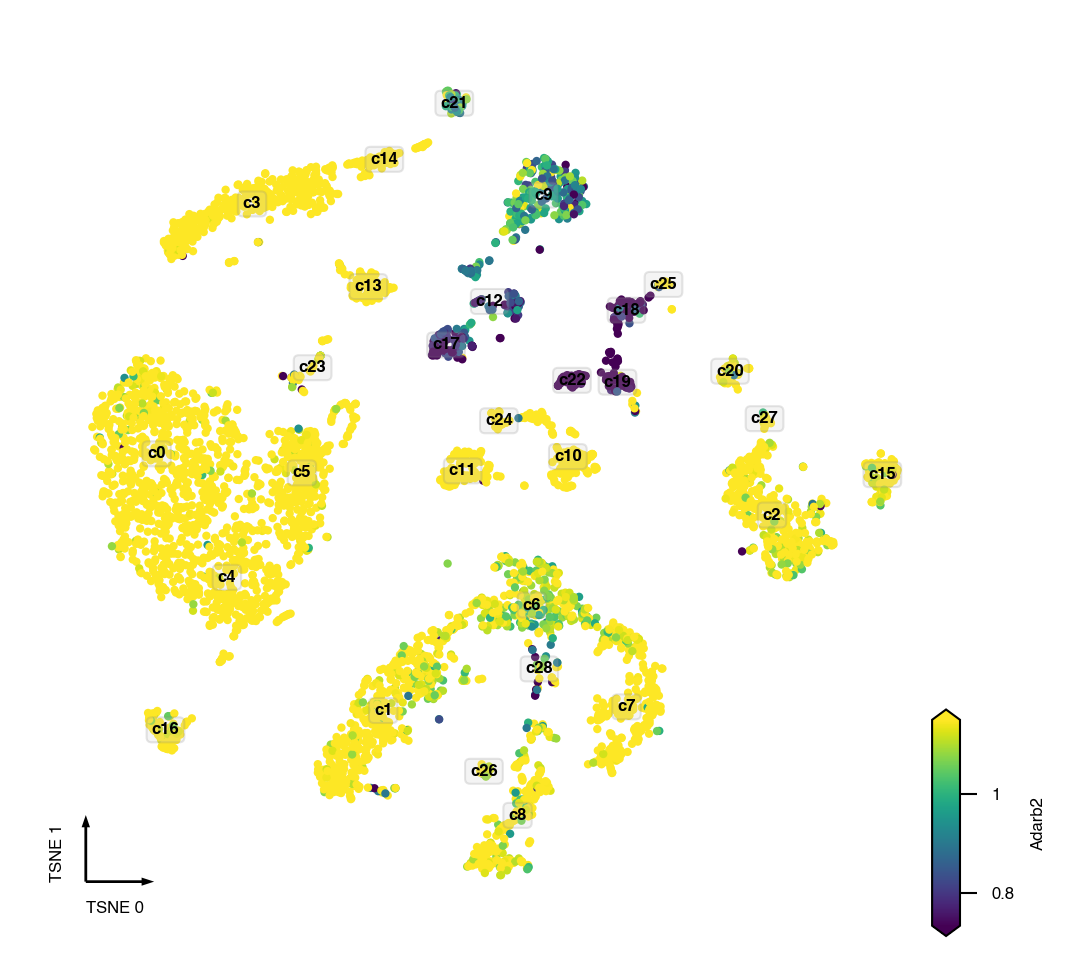

In [7]:
gene = 'Adarb2'
hue_norm = (0.67, 1.5)
coord_base = 'tsne'

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

_ = continuous_scatter(ax=ax,
                       data=adata.obs,
                       hue=get_gene_values_by_name(gene),
                       hue_norm=hue_norm,
                       text_anno=cluster_col,
                       coord_base=coord_base,
                       max_points=None,
                       s=4)

### Plot Cluster Top Markers

In [8]:
def plot_cluster_and_genes(cluster, cell_meta, cluster_col, genes_data,
                           coord_base='umap', ncols=5, axes_size=3, dpi=150, hue_norm=(0.67, 1.5)):
    ncols = max(2, ncols)
    nrows = 1 + (genes_data.shape[1] - 1) // ncols + 1

    # figure
    fig = plt.figure(figsize=(ncols * axes_size, nrows * axes_size), dpi=dpi)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    # cluster axes
    ax = fig.add_subplot(gs[0, 0])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        axis_format=None,
                        hue=cluster_col,
                        palette='tab20')
    ax.set_title('All Clusters')
    ax = fig.add_subplot(gs[0, 1])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        hue=cell_meta[cluster_col] == cluster,
                        axis_format=None,
                        palette={
                            True: 'red',
                            False: 'lightgray'
                        })
    ax.set_title('This Cluster')

    # gene axes
    for i, (gene, data) in enumerate(genes_data.iteritems()):
        col = i % ncols
        row = i // ncols + 1
        ax = fig.add_subplot(gs[row, col])

        if ax.is_first_col() and ax.is_last_row():
            axis = 'tiny'
        else:
            axis = None

        continuous_scatter(ax=ax,
                           data=cell_meta,
                           hue=data,
                           axis_format=axis,
                           hue_norm=hue_norm,
                           coord_base=coord_base)
        ax.set_title(f'{data.name}')
    fig.suptitle(f'Cluster {cluster} Top Markers')
    return fig

### Per Cluster Plots

In [9]:
cluster_dmgs.head()

,pvals_adj,fc,AUROC,cluster
names,,,,
ENSMUSG00000039621.13,2.174683e-236,0.337890,0.982570,c1
ENSMUSG00000021219.16,1.010769e-223,0.427713,0.969285,c1
ENSMUSG00000029705.17,1.218428e-215,0.172890,0.960626,c1
ENSMUSG00000035357.16,6.196632e-215,0.295413,0.959746,c1
ENSMUSG00000042589.18,3.960221e-207,0.323577,0.951288,c1


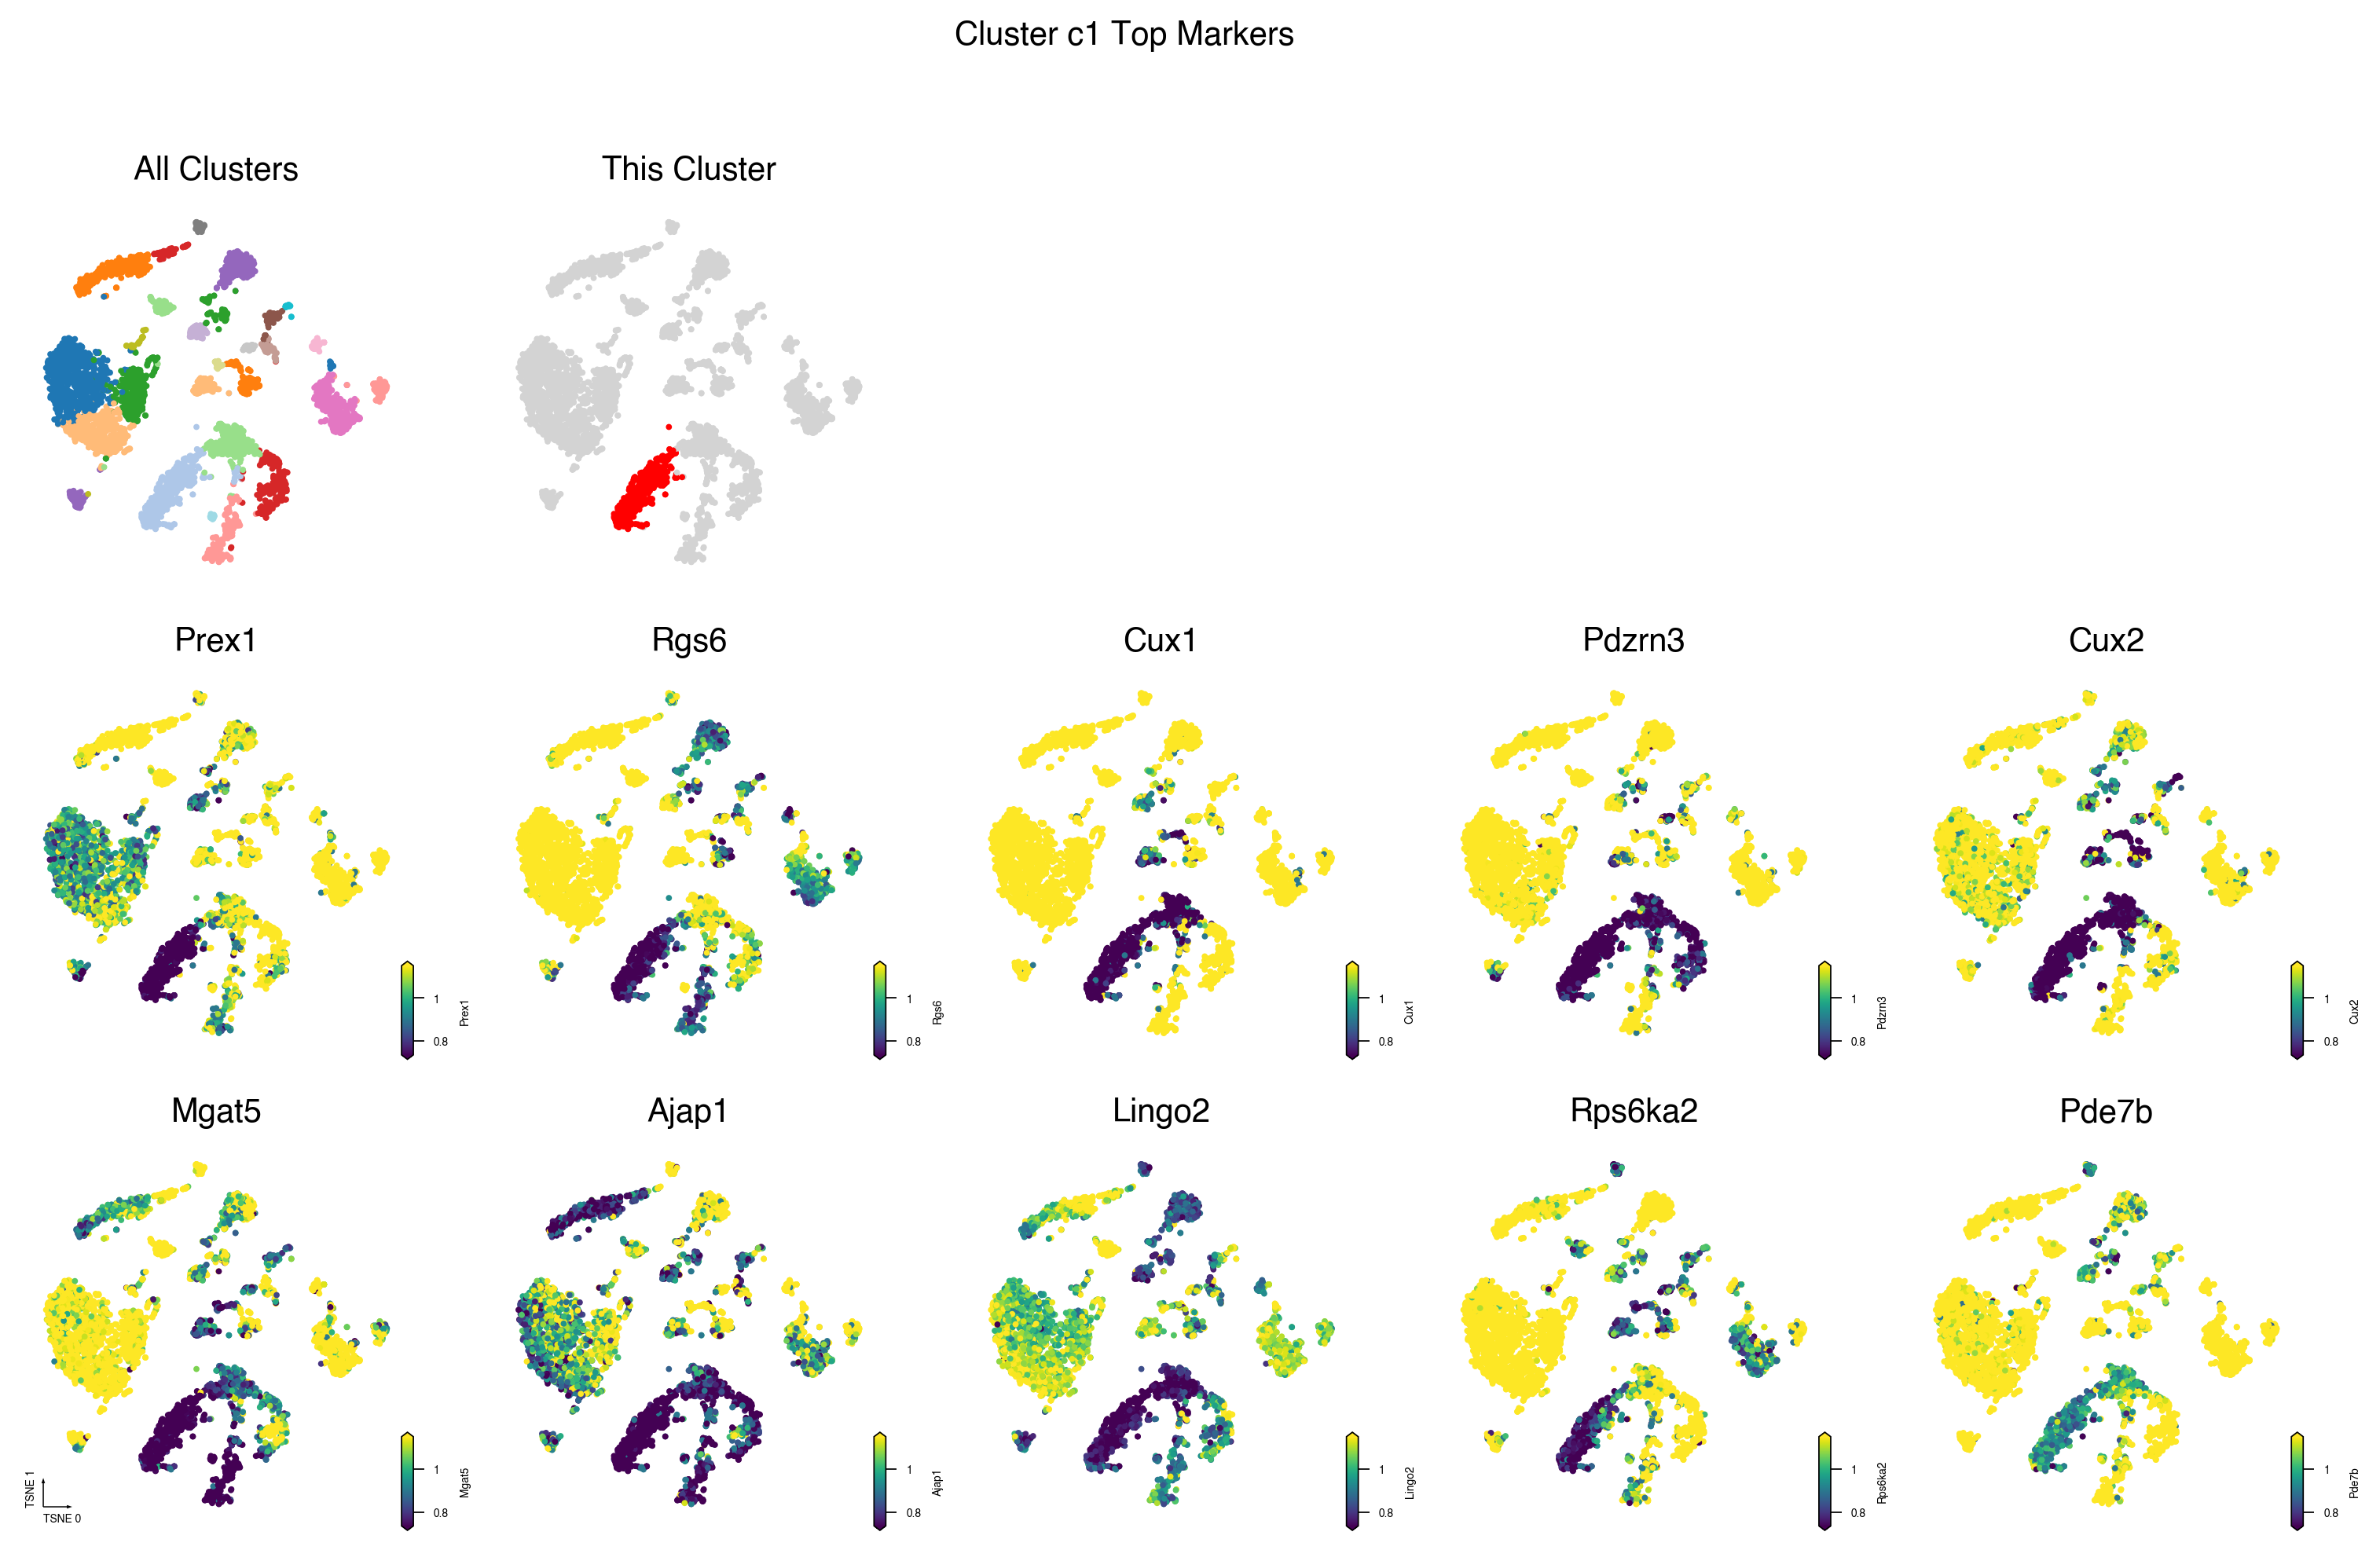

In [12]:
cluster = 'c1'
genes = cluster_dmgs[cluster_dmgs['cluster'] == cluster].sort_values(
    'AUROC', ascending=False)[:10]
genes_data = gene_frac_da.sel(gene=genes.index).to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])

fig = plot_cluster_and_genes(cluster=cluster,
                             cell_meta=adata.obs,
                             cluster_col=cluster_col,
                             genes_data=genes_data,
                             coord_base='tsne',
                             ncols=5,
                             axes_size=3,
                             dpi=250,
                             hue_norm=(0.67, 1.5))

fig.savefig(f'{cluster}.TopMarker.png', bbox_inches='tight')